# Evaluating pre-trained GPT-4.1-mini


In [32]:
import os
import sys

sys.path.append("../scripts")

import time

import pandas as pd
from metrics import per_source_metrics
from openai import AzureOpenAI
from plot_utils import plot_confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm

In [ ]:
endpoint = os.getenv("AZURE_ENDPOINT")
model_deployment_name = "gpt-4.1-mini"

subscription_key = os.getenv("AZURE_API_KEY")
api_version = "2024-12-01-preview"

In [ ]:
client = AzureOpenAI(
    api_version=api_version,
    azure_endpoint=endpoint,
    api_key=subscription_key,
)

In [ ]:
response = client.chat.completions.create(
    messages=[
        {
            "role": "system",
            "content": "You are a helpful assistant.",
        },
        {
            "role": "user",
            "content": "I am going to Paris, what should I see?",
        },
    ],
    max_completion_tokens=10,
    temperature=1.0,
    top_p=1.0,
    frequency_penalty=0.0,
    presence_penalty=0.0,
    model=model_deployment_name,
)

print(response.choices[0].message.content)

That’s exciting! Paris has so much to offer


In [ ]:
val_df = pd.read_csv("../data/processed/val.csv")

In [ ]:
prompts = [
    {
        "role": "system",
        "content": "You are a financial sentiment classifier. Respond with one word: neutral, positive, or negative.",
    }
]

sentences = val_df["sentence"].tolist()
true_labels = val_df["label"].tolist()

In [ ]:
preds = []

for sentence in tqdm(sentences):
    response = client.chat.completions.create(
        messages=prompts
        + [
            {
                "role": "user",
                "content": f"Classify the sentiment of this sentence: {sentence}",
            }
        ],
        max_completion_tokens=1,
        model=model_deployment_name,
    )
    result = response.choices[0].message.content.strip().lower()
    preds.append(result)
    # time.sleep(0.5)  # To avoid hitting rate limits

    # print(f"{i}\ngpt-4.1-mini-ft: {result}\nvalidation: {true_labels[i]}\n")

100%|██████████| 1781/1781 [18:09<00:00,  1.63it/s] 


In [ ]:
with open("../models/gpt-4.1/gpt-4.1-mini-preds.txt", "w") as f:
    for label in preds:
        f.write(label + "\n")

In [ ]:
report = classification_report(true_labels, preds)
print(report)

              precision    recall  f1-score   support

    negative       0.61      0.89      0.73       274
     neutral       0.90      0.55      0.68      1064
    positive       0.54      0.88      0.67       443

    accuracy                           0.69      1781
   macro avg       0.68      0.78      0.69      1781
weighted avg       0.76      0.69      0.69      1781



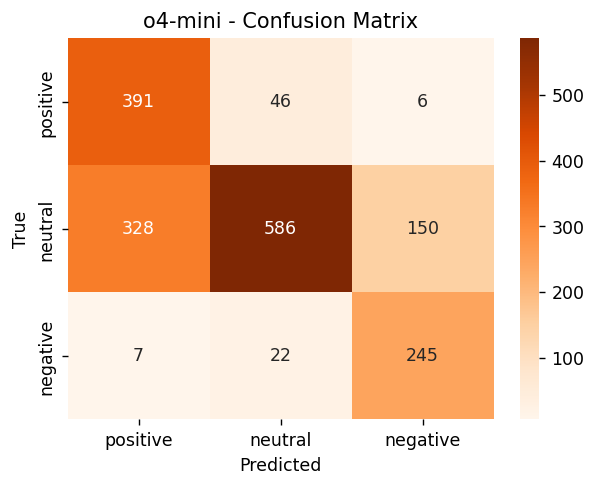

In [ ]:
plot_confusion_matrix(
    true_labels,
    preds,
    labels=["positive", "neutral", "negative"],
    title="o4-mini - Confusion Matrix",
    cmap="Oranges",
)

In [33]:
per_source_results = per_source_metrics(true_labels, preds, val_df["source"])
print("GPT-4.1-mini-fine-tuned Per-Source Performance:\n")
for source, acc, f1 in per_source_results:
    print(f"{source}: Accuracy={acc:.3f}, Macro-F1={f1:.3f}")

GPT-4.1-mini-fine-tuned Per-Source Performance:

FPB: Accuracy=0.743, Macro-F1=0.764
Twitter: Accuracy=0.656, Macro-F1=0.657
FiQA: Accuracy=0.759, Macro-F1=0.656


In [34]:
pd.DataFrame(
    classification_report(true_labels, preds, output_dict=True)
).transpose().to_csv("../models/gpt-4.1/gpt-4.1-mini-preds.csv")